In [1]:
%pylab inline 
import face_recognition
import cv2
import matplotlib.patches as patches
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from datetime import datetime
import time

from skimage.measure import compare_ssim
import pyscreenshot as ImageGrab
import imutils

Populating the interactive namespace from numpy and matplotlib


In [2]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [3]:
def img_diff(imageA, imageB):
    max_w, max_h = None, None
    if imageA.shape[:2] != imageB.shape[:2]:
        max_w = max(imageA.shape[0], imageB.shape[0])
        max_h = max(imageA.shape[1], imageB.shape[1])
    
    # convert the images to grayscale
    if max_w or max_h:
        grayA = cv2.cvtColor(
            imutils.resize(imageA, width=max_w, height=max_h), cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(
            imutils.resize(imageB, width=max_w, height=max_h), cv2.COLOR_BGR2GRAY)
        if grayA.shape != grayB.shape:
            gray_max_w = max(grayA.shape[0], grayB.shape[0])
            gray_max_h = max(grayA.shape[1], grayB.shape[1])
            right_a, bottom_a = gray_max_h-grayA.shape[1],  gray_max_w-grayA.shape[0]
            right_b, bottom_b = gray_max_h-grayB.shape[1],  gray_max_w-grayB.shape[0]
            if (bottom_a, right_a) != (0, 0):
                grayA = cv2.copyMakeBorder(
                    grayA, 0, bottom_a, 0, right_a,
                    cv2.BORDER_CONSTANT, value=(0, 0, 0))
            if (bottom_b, right_b) != (0, 0):
                o_grayB = grayB.copy()
                grayB = cv2.copyMakeBorder(
                    grayB, 0, bottom_b, 0, right_b,
                    cv2.BORDER_CONSTANT, value=(0, 0, 0))
    else:
        grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
        
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    print("SSIM: {}".format(score))
    return score

Wednesday, February 19, 2020 12:11:32


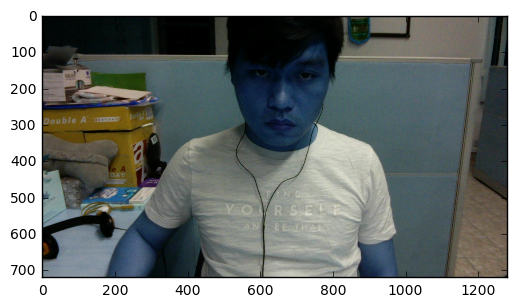

Wednesday, February 19, 2020 12:11:35


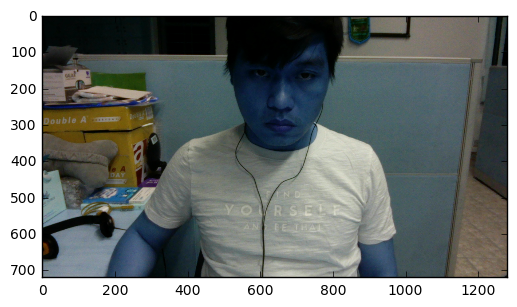

Wednesday, February 19, 2020 12:11:39


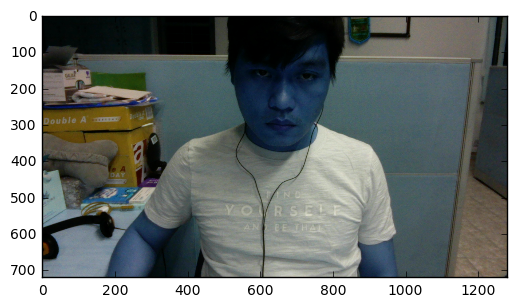

SSIM: 0.9054668098831308
SSIM: 0.8944488294015847
working time: 0s - free time: 4.887887001037598s
Wednesday, February 19, 2020 12:11:44


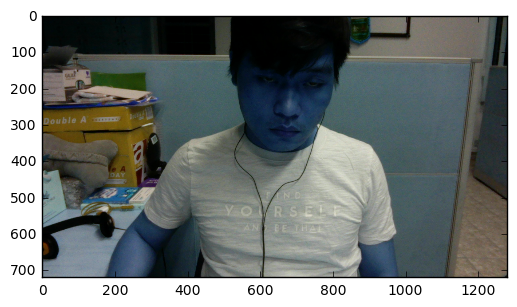

SSIM: 0.8456608530478329
SSIM: 0.8293005036358593
working time: 0s - free time: 9.466456174850464s
Wednesday, February 19, 2020 12:11:48


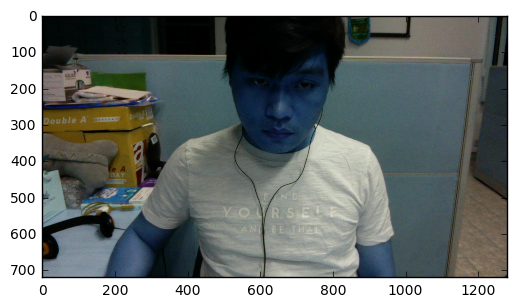

SSIM: 0.7946638121712588
working time: 4.3318259716033936s - free time: 9.466456174850464s


In [4]:
workingtime = 0
freetime = 0
hr_report = pd.DataFrame(columns = ['Time', 'Note', 'Image'])
timestep = 3

video_capture = cv2.VideoCapture(0)
ret, frame_before2 = video_capture.read()
print(datetime.fromtimestamp(time.time()).strftime("%A, %B %d, %Y %I:%M:%S"))
plt.imshow(frame_before2)
plt.show()
time.sleep(timestep)

ret, frame_before1 = video_capture.read()
print(datetime.fromtimestamp(time.time()).strftime("%A, %B %d, %Y %I:%M:%S"))
plt.imshow(frame_before1)
plt.show()
time.sleep(timestep)

t_start = time.time()

while video_capture.isOpened():
    # Release handle to the webcam
    if (time.time() - 12) > t_start:
        video_capture.release()
        break
    t = time.time()    
    # Grab a single frame of video
    ret, frame = video_capture.read()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    time_check = datetime.fromtimestamp(time.time()).strftime("%A, %B %d, %Y %I:%M:%S")
    print(time_check)
    plt.imshow(frame)
    plt.show()
    
    face_locations = face_recognition.face_locations(frame)
    
    if len(face_locations) == 0:
        df_temp = pd.DataFrame(columns = ['Time', 'Note', 'Image'])
        df_temp['Time'] = [time_check]
        df_temp['Note'] = ['Can not detect face']
        df_temp['Image'] = [frame]
        hr_report = pd.concat([hr_report, df_temp])

        freetime += timestep + time.time() - t
    else:
        if img_diff(frame_before1, frame) > 0.8:
            if img_diff(frame_before2, frame) > 0.8:
                df_temp = pd.DataFrame(columns = ['Time', 'Note', 'Image'])
                df_temp['Time'] = [time_check]
                df_temp['Note'] = ['Screen no change']
                df_temp['Image'] = [frame]
                hr_report = pd.concat([hr_report, df_temp])

                freetime += timestep + time.time() - t
            else:
                workingtime += timestep + time.time() - t
                frame_before2 = frame_before1
                frame_before1 = frame
        else:
            workingtime += timestep + time.time() - t
            frame_before2 = frame_before1
            frame_before1 = frame
            
    print('working time: %ss - free time: %ss' % (workingtime, freetime))
    time.sleep(timestep)

In [5]:
hr_report = hr_report.reset_index(drop=True)
hr_report

,Time,Note,Image
0,"Wednesday, February 19, 2020 12:11:39",Screen no change,"[[[0, 1, 3], [0, 2, 4], [0, 4, 4], [0, 5, 5], ..."
1,"Wednesday, February 19, 2020 12:11:44",Screen no change,"[[[0, 2, 1], [0, 3, 2], [0, 5, 5], [2, 6, 6], ..."
